# Model 1 classifier 

This classifier will determine wheter a review is a `requirement`, `bug report` or another category as `other`.
The approach will be the following: 
1. Import fully labled dataset. 
1. Only take the columns that are necessary and rename unclear column names.
1. Merge the `other` and `noise` label together to `other`. 
1. Research the data charecteristics
  * Make a wordcloud of the dataset. 
  * Make a barchart with the balance of the labels. 
1. Preprocess the data.
  * Refactor to all lower case.
  * Remove punctuation marks. 
  * Stemming with porter. 
  * Remove stop words.
  * Remove plural.
  * Remove unnecesary words from wordcloud like `app` or something.
1. Create train, validate and test data. (70%, 15%, 15%) 
  * Use train data to train the models with. 
  * Use validate data to validate different models, and cheks who is the best.
  * Use test data to test the validated model. (Model who have won in the above step). 
1. Use different models for classifing the review.


In [1]:
# Helpers. 
import numpy as numpy # For generating random probabilities to split into train-test dataset
import pandas as pandas # For loading data
import itertools
import os

# Visualizations.
import matplotlib.pyplot as plt # Matplotlib for barcharts.
from wordcloud import WordCloud # WordCloud for visualization of the revies.

# Pre-processing.
import re as regex # Regex support for python.
import nltk # The Natural Language Toolkit. 

from nltk.corpus import stopwords # For removing stopwords
from nltk.stem.porter import PorterStemmer # For stemming
from nltk.stem import WordNetLemmatizer

# Feature engineering.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# ML Algorithms.
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Model analysis.
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

# Neural network.
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quinten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/quinten/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/quinten/Documents/Programming/Git/school/python/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/quinten/Documents/Programming/Git/school/python/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/quinten/Documents/Programming/Git/school/python

## Functions

In this section are all the functions that are used in this file. 

In [2]:
def displayWordCloud(label):
  category = ' '.join(list(df[df['label'] == label] ['text']))
  cloud = WordCloud(width = 1000, height = 500).generate(category)
  plt.figure(figsize = (15,8), facecolor = 'k')
  plt.imshow(cloud, interpolation = "bilinear")
  plt.axis("off")
  plt.show()
    
def displayBarChart(column):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  column.value_counts().plot(kind = 'bar', color = '#12f12f', alpha = 0.5, grid = True)
  plt.ylabel('counts')
  plt.title('Distribution of label category')
  plt.xticks(rotation = 'horizontal')
  ax.xaxis.grid(which = "major")
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  for p in ax.patches:
    ax.annotate(numpy.round(p.get_height(), decimals = 2), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va ='center')

Below you'll find some functions which will help building a model. Since the base of those models are quite the same, we've generalized it to a more generic function. 

In [3]:
def model(model, title, trainData, labelTrain, validateData, labelValidate):
    # Train the model.
    model.fit(trainData, labelTrain)
    # Make predections.
    predictions = model.predict(validateData)

    print(title)
    print('Acurracy score: %s\n' % accuracy_score(predictions, labelValidate))
    print(classification_report(labelValidate, predictions))
    
    return model

def svmModel(trainData, labelTrain, validateData, labelValidate):
    svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
    return model(svm, 'SUPPORT VECTOR MACHINE: \n', trainData, labelTrain, validateData, labelValidate)

def bayesModel(trainData, labelTrain, validateData, labelValidate):
    bayesModel = MultinomialNB()
    return model(bayesModel, 'GAUSSIAN NAIVE BAYES: \n', trainData, labelTrain, validateData, labelValidate)

def logisticRegressionModel(trainData, labelTrain, validateData, labelValidate):
    logisticRegressionModel = LogisticRegression(n_jobs = 1, C = 1e5, solver = 'newton-cg', multi_class = 'multinomial')
    return model(logisticRegressionModel, 'LOGISTIC REGRESSION: \n', trainData, labelTrain, validateData, labelValidate)

In [4]:
def cleanReviews(data):
    # The corpus of the reviews, the place where all the pre-processed data will be.
    corpus = []
    customStopwords = {'update', 'app', 'time', 
                   'iphone', 'phone', 'use', 
                   'waze', 'facebook', 'fitbit', 
                   'instagram', 'pinterest', 'whatsapp', 
                   'fitbit', 'myfitnesspal', 'fit'}

    for i in range(0, len(data)):
        stemmer = PorterStemmer()

        # Remove punctuation. 
        refinedReview = regex.sub('[^a-zA-Z]', ' ', data[i])
        # To lowercase.
        refinedReview = refinedReview.lower()
        # Split the words, and put every word in an array, this is neccesary for the stemmer. 
        refinedReview = refinedReview.split()
        # Remove custom stopwords.
        refinedReview = [word for word in refinedReview if word not in customStopwords]
        # Stem the review. 
        refinedReview = [WordNetLemmatizer().lemmatize(word) for word in refinedReview if not word in set(sw)]
        # Concat the array element to each other, to get one review string.
        refinedReview = ' '.join(refinedReview)
    
        corpus.append(refinedReview)
    
    return corpus

## Data cleaning

First we will import and clean the dataset. We will rename columns, concat the topic and review column. Determine if all the label values are not NaN. 

In [5]:
# Load the data into the dataframe
df = pandas.read_excel('data/input/reviews.xlsx')
df.head()

Unnamed: 0  app_name    user_id        user_name                 date  \
0     52505.0  Facebook  246193109     Help is herr  2017-06-21 00:00:00   
1     53247.0  Facebook   43034279        javamdnss  2017-06-16 00:00:00   
2     47018.0  Facebook  496978255              NaN  2017-05-27 00:00:00   
3     41850.0  Facebook  139595037      Gilbertiggy  2017-05-26 00:00:00   
4     41683.0  Facebook  180832062  Princess Lou 24  2017-06-01 00:00:00   

          country version  score                               topic  \
0   United States      97      1        Notifications not showing up   
1   United States      97      1                            Hate it!   
2       Hong Kong      94      1  Useless function n poor experience   
3  United Kingdom      94      1                    To many updates!   
4  United Kingdom      94      1                        Photo albums   

                                              review  \
0  The notification badges are showing up on my i...   
1  Why do they make changes we don't need? Now th...   
2  Story is useless n annoying to user. \nCan't s...   
3  This app is always having an update for someth...   
4  Just spent an hour trying to upload photos and...   

                                                 url  review_id  \
0  https://itunes.apple.com/WebObjects/MZStore.wo...    53163.0   
1  https://itunes.apple.com/WebObjects/MZStore.wo...    53905.0   
2  https://itunes.apple.com/WebObjects/MZStore.wo...    47401.0   
3  https://itunes.apple.com/WebObjects/MZStore.wo...    42233.0   
4  https://itunes.apple.com/WebObjects/MZStore.wo...    42066.0   

  category_final sentiment_final       req_final  
0    requirement         neutral      functional  
1          other   very negative             NaN  
2          other        negative             NaN  
3    requirement        negative      functional  
4    requirement        negative  non-functional

Clean the dataset, concat topic an review. Only select the text and category_final columns, and rename it to label. Change noise to other. 

In [6]:
# Parse column type to string.
df['topic'] = df['topic'].apply(str)
df['review'] = df['review'].apply(str)

In [7]:
df['text'] = df['topic'] + ' ' + df['review'] # Concat the topic and review column to text column.

df = df.loc[:, ['text', 'category_final']] # Only select the label and text column.

df = df.rename(columns={'category_final': 'label'}) # Rename columns.

df['label'] = df['label'].str.lower() # Make all labels the same from upper case to lower case.

df['label'] = numpy.where(df['label'] == 'noise', 'other', df['label']) # Change noise to other.

In [8]:
# Determine if there any missing values, and look at the different labels. 
df['label'].unique() 

array(['requirement', 'other', 'bug report'], dtype=object)

In [9]:
# Represent the labels as numbers (requirement: 0, bug report: 1, other: 2).
df.loc[:, ('label')] = numpy.where(df.loc[:, ('label')] == 'requirement', 0, 
                numpy.where(df.loc[:, ('label')] == 'bug report', 1, 2))

Dataframe must be shuffled in order to get a better result of the model, otherwise the model can take advantage of the order of the dataframe. 

In [10]:
# Shuffle the dataframe rows. Overwrite the old values. 
df = df.sample(frac = 1).reset_index(drop = True)

In [11]:
df.head()

text  label
0  Waze! Is tracking you! I do use Waze a lot. Ho...      2
1  Last update stinks Will not play videos at all...      1
2  Dependable and very useful app Very happy with...      2
3  Love it, but I love Instagram and I am a daily...      2
4  Pinterest What's up with the new update.  Used...      0

## Data exploration and visualization

To obtain some more infomration about the data and get a better understanding of the data we'll use some visualizations. First we will make a wordcloud for all the words in the reviews, to determine if we can remove some words from te reviews. 

Then we'll make a bar chart with the distribution of the amount of `requirement`, `bug report` or `other` labels. 

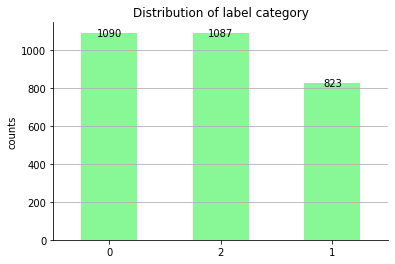

In [12]:
displayBarChart(df['label'])

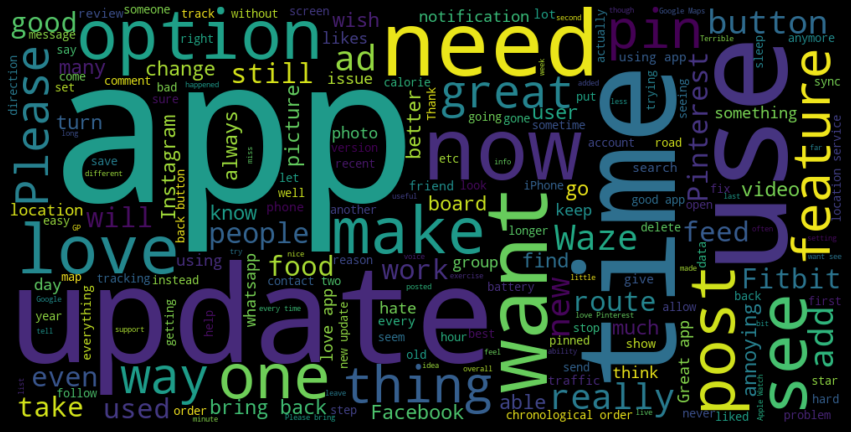

In [13]:
displayWordCloud(0) # Requirements wordcloud.

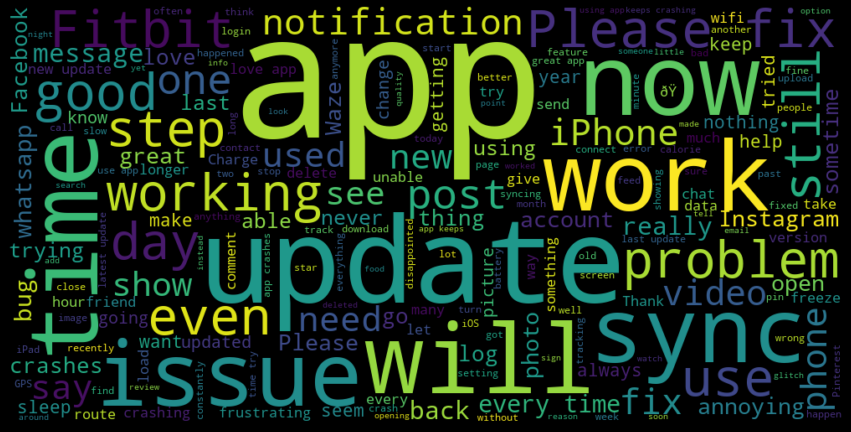

In [14]:
displayWordCloud(1) # Bug report wordcloud.

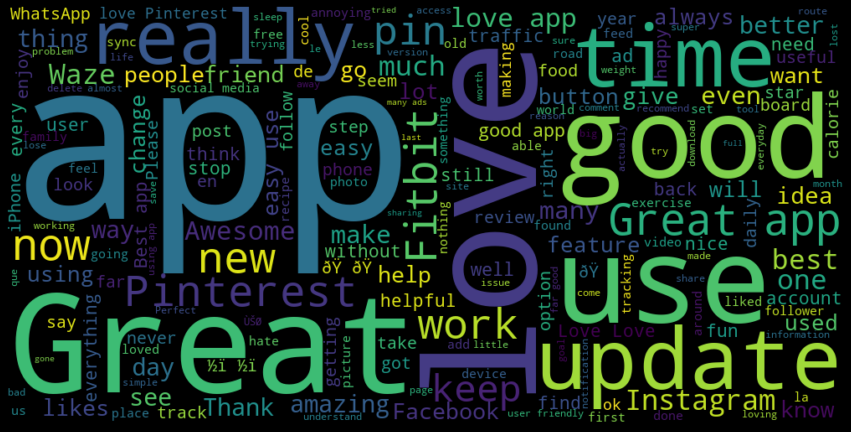

In [15]:
displayWordCloud(2) # Other wordcloud.

## Pre-processing data

In this section we'll pre-process the data. We will do the following things: 

 * Refactor to all lower case;
   * To make `Get` and `get` the equivelent, no need for upper cases.
 * Remove punctuation marks;
   * Only for sentiment punctuation marks can be handy.
 * Remove plural;
   * Makes it easy to determine the same word as plural. This is done by the porter stemmer.
 * Stemming with porter; 
   * Refactors `walking` to `walk`. 
 * Remove stop words;
   * Remove natural english stop words. Those words doesn't give away information.
 * Remove unnecesary words from wordcloud. 
   * 'update', 'app', 'time', 'iphone', 'phone', 'use'


In [16]:
# Load the english stopwords
sw = stopwords.words("english")

In [17]:
# Split the text column from label column to easly pre-process.
textColumn = df['text'] 
labelColumn = df['label'].tolist()

In [18]:
# The corpus of the reviews, the place where all the pre-processed data will be.
corpus = cleanReviews(textColumn)

## Train, validate and test sets

In [19]:
# Split text data into 70, 15, 15 ratio.
textTrain, textTest, textValidate  = numpy.split(corpus, [int(.7*len(corpus)), int(.85*len(corpus))])

# Split label data into 70, 15, 15 ratio.
labelTrain, labelTest, labelValidate  = numpy.split(labelColumn, [int(.7*len(labelColumn)), int(.85*len(labelColumn))])

In [20]:
# Training set sneak peak.
textTrain[1:5]

array(['last stink play video even though good service home wifi keep telling new notification automatically take post commented every someone else comment even though clicking notification frustrating please fix',
       'dependable useful happy',
       'love love daily poster feed scroller however follow many account see handful one always order posting sure great big business celebrity etc small fish big pond still want see friend artist small brand everything posting daily scrolling also feel impact exposure page becoming harder make connection like mind people around world new setting making connection important part freelance business believe affected reason give used favourite star',
       'new used pin could handle run minute worth'], dtype='<U1138')

## Feature engineering, TF-IDF Vector

In this section we will abstract from the text some features, and parse the text to number. We'll do this by converting the text to a `Term Frequency-Inverse Document Frequency`. This approach represents the relative importance of a term in a document.

In [21]:
# Create the vectorizer. min_df to get rid of extremly rare words. max_df to get rid of the extremly often used words.
vectorizer = TfidfVectorizer(min_df = 5, max_df = .75)
# Use bag of words.
countVectorizer = CountVectorizer()

# Setup training data and test data.
trainDataTFIDF = vectorizer.fit_transform(textTrain).toarray()
validateDataTFIDF = vectorizer.transform(textValidate).toarray()
testDataTFIDF = vectorizer.transform(textTest).toarray()

print('TFIDF \n')
print('Number of features = {}'.format(len(vectorizer.vocabulary_)))
print('Train shape = ', trainDataTFIDF.shape)
print('Validate shape = ', validateDataTFIDF.shape)
print('Test shape = ', testDataTFIDF.shape)

trainDataCV = countVectorizer.fit_transform(textTrain).toarray()
validateDataCV = countVectorizer.transform(textValidate).toarray()
testDataCV = countVectorizer.transform(textTest).toarray()

print('\nCV \n')
print('Number of features = {}'.format(len(countVectorizer.vocabulary_)))
print('Train shape = ', trainDataCV.shape)
print('Validate shape = ', validateDataCV.shape)
print('Test shape = ', testDataCV.shape)

# Take a look at the tfidf matrix. 
frequencyMatrix = pandas.DataFrame(trainDataTFIDF, columns = vectorizer.get_feature_names())
frequencyMatrix.head()

TFIDF 

Number of features = 1172
Train shape =  (2100, 1172)
Validate shape =  (450, 1172)
Test shape =  (450, 1172)

CV 

Number of features = 4722
Train shape =  (2100, 4722)
Validate shape =  (450, 4722)
Test shape =  (450, 4722)


ability  able  absolutely  accept  access  accident  accidentally  \
0      0.0   0.0         0.0     0.0     0.0       0.0           0.0   
1      0.0   0.0         0.0     0.0     0.0       0.0           0.0   
2      0.0   0.0         0.0     0.0     0.0       0.0           0.0   
3      0.0   0.0         0.0     0.0     0.0       0.0           0.0   
4      0.0   0.0         0.0     0.0     0.0       0.0           0.0   

    account  accurate  active  ...  writing  wrong  wth  year  yes  yesterday  \
0  0.000000       0.0     0.0  ...      0.0    0.0  0.0   0.0  0.0        0.0   
1  0.000000       0.0     0.0  ...      0.0    0.0  0.0   0.0  0.0        0.0   
2  0.000000       0.0     0.0  ...      0.0    0.0  0.0   0.0  0.0        0.0   
3  0.109357       0.0     0.0  ...      0.0    0.0  0.0   0.0  0.0        0.0   
4  0.000000       0.0     0.0  ...      0.0    0.0  0.0   0.0  0.0        0.0   

   yet  zero  zone  zoom  
0  0.0   0.0   0.0   0.0  
1  0.0   0.0   0.0   0.0  
2  0.0   0.0   0.0   0.0  
3  0.0   0.0   0.0   0.0  
4  0.0   0.0   0.0   0.0  

[5 rows x 1172 columns]

## Modeling

In this section we'll make our machine learning models. We'll fit the models and determine their correctness. 

The models that we are going to validate are: 
  * Naive Bayes Classifier - Multinomial Model
  * Linear Support Vector Machine
  * Logistic Regression

### Multinomial Naive Bayes

In [22]:
print('------ Bag of words engineering ------')
bayesModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
bayesModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.6977777777777778

              precision    recall  f1-score   support

           0       0.60      0.79      0.68       156
           1       0.69      0.75      0.72       114
           2       0.88      0.58      0.70       180

    accuracy                           0.70       450
   macro avg       0.72      0.71      0.70       450
weighted avg       0.73      0.70      0.70       450

------ TFIDF engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.7066666666666667

              precision    recall  f1-score   support

           0       0.60      0.78      0.68       156
           1       0.78      0.70      0.74       114
           2       0.80      0.65      0.72       180

    accuracy                           0.71       450
   macro avg       0.73      0.71      0.71       450
weighted avg       0.73      0.71      0.71       450



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Support Vector Machine

In [23]:
print('------ Bag of words engineering ------')
svmModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
svmTrainedModel = svmModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

print('------ TFIDF engineering test set ------')
svmModel(trainDataTFIDF, labelTrain, testDataTFIDF, labelTest)

------ Bag of words engineering ------
SUPPORT VECTOR MACHINE: 

Acurracy score: 0.7244444444444444

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       156
           1       0.70      0.70      0.70       114
           2       0.76      0.76      0.76       180

    accuracy                           0.72       450
   macro avg       0.72      0.72      0.72       450
weighted avg       0.72      0.72      0.72       450

------ TFIDF engineering ------
SUPPORT VECTOR MACHINE: 

Acurracy score: 0.7488888888888889

              precision    recall  f1-score   support

           0       0.67      0.79      0.73       156
           1       0.80      0.65      0.72       114
           2       0.81      0.77      0.79       180

    accuracy                           0.75       450
   macro avg       0.76      0.74      0.74       450
weighted avg       0.76      0.75      0.75       450

------ TFIDF engineering test set ------
SU

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Neural network

In [25]:
max_words = df['text'].str.split().str.len().max()
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(textTrain) # only fit on train

x_train = tokenize.texts_to_matrix(textTrain)
x_validate = tokenize.texts_to_matrix(textValidate)
x_test = tokenize.texts_to_matrix(textTest)

encoder = LabelEncoder()
encoder.fit(labelTrain)
y_train = encoder.transform(labelTrain)
y_validate = encoder.transform(labelValidate)
y_test = encoder.transform(labelTest)

num_classes = numpy.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_validate = utils.to_categorical(y_validate, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

Build and train model.

In [26]:
batch_size = 32
epochs = 15

# Build the model
model = Sequential()
model.add(Dense(len(textTrain), input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model.             
history = model.fit(x_train, y_train, batch_size=batch_size, epochs = epochs,verbose = 1,validation_split = 0.1)


Train on 1890 samples, validate on 210 samples
Epoch 1/15
1890/1890 [==============================] - 1s 578us/step - loss: 0.8221 - accuracy: 0.6376 - val_loss: 0.6738 - val_accuracy: 0.7476
Epoch 2/15
1890/1890 [==============================] - 0s 247us/step - loss: 0.4837 - accuracy: 0.8206 - val_loss: 0.6798 - val_accuracy: 0.7429
Epoch 3/15
1890/1890 [==============================] - 0s 253us/step - loss: 0.3323 - accuracy: 0.8899 - val_loss: 0.7385 - val_accuracy: 0.7095
Epoch 4/15
1890/1890 [==============================] - 1s 281us/step - loss: 0.2316 - accuracy: 0.9333 - val_loss: 0.7850 - val_accuracy: 0.7000
Epoch 5/15
1890/1890 [==============================] - 0s 263us/step - loss: 0.1578 - accuracy: 0.9651 - val_loss: 0.8156 - val_accuracy: 0.7048
Epoch 6/15
1890/1890 [==============================] - 0s 259us/step - loss: 0.1075 - accuracy: 0.9788 - val_loss: 0.8512 - val_accuracy: 0.7143
Epoch 7/15
1890/1890 [==============================] - 0s 255us/step - loss

In [27]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_validate, y_validate, batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

450/450 [==============================] - 0s 49us/step
Test score: 1.419142648908827
Test accuracy: 0.7111111283302307


## Final requirements elicitation

According to all the classifers' results, we've chosen to pick the support vector machine for our whole dataset. 

We will load the whole unlabled dataset, and then apply it to our model. We will save the results to a file called `model-1-results` and in the file `combine-results` will the results be combined. 

In [76]:
totaldf = pandas.read_csv('data/input/unlabelledDataset.csv') # Read the unlabled dataset.

In [77]:
# Concat the topic and review column to text column.
totaldf['text'] = totaldf['topic'].apply(str) + ' ' + totaldf['review'].apply(str) 

# Generate a corpus and tfidf to fed in the model.
corpus = cleanReviews(totaldf['text'].apply(str))
tfidf = vectorizer.transform(corpus).toarray()

In [78]:
# Make predictions with the svm. 
labels = svmTrainedModel.predict(tfidf)

# Represent the labels as text ( 0: requirement, 1: bug report, 2: other).
textLabels = numpy.where(labels == 0, 'requirement', 
                numpy.where(labels == 1, 'bug report', 'other'))

In [86]:
# Create a new dataframe with the labels and reviews
result = pandas.DataFrame(data= {'labels': textLabels, 'reviews': totaldf['text']})
result.head()

labels                                             review
0  requirement  Fix this app You continually update this app a...
1  requirement  Really? The new comments section on videos is ...
2        other                                      Useful Useful
3  requirement  Icons I don't enjoy that the icons on the bott...
4  requirement  Annoying Updated the app despite my gut feelin...

### Data visualization

As you can see in the bar chart below are the labels not really equally distributed. 

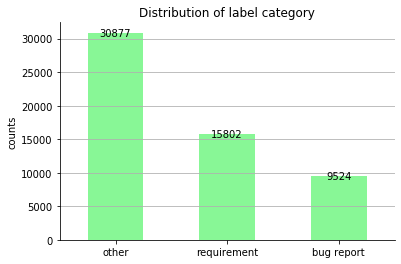

In [90]:
displayBarChart(result['labels'])

In [92]:
# Write result to csv file.
result.to_csv('data/output/model-1-results.csv', index = False)